## Flu and Variant-Specific Booster Uptake at the State Level

In this notebook, we look at the avaialability of flu clinics and compare it COVID variant-specific booster uptake within each of the U.S. 50 states. 

In [21]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [22]:
date_list = ["11/02/2022"]

state_list = [
    "AL",
    "AK",
    "AZ",
    "AR",
    "CA",
    "CO",
    "CT",
    "DE",
    "FL",
    "GA",
    "HI",
    "ID",
    "IL",
    "IN",
    "IA",
    "KS",
    "KY",
    "LA",
    "ME",
    "MD",
    "MA",
    "MI",
    "MN",
    "MS",
    "MO",
    "MT",
    "NE",
    "NV",
    "NH",
    "NJ",
    "NM",
    "NY",
    "NC",
    "ND",
    "OH",
    "OK",
    "OR",
    "PA",
    "RI",
    "SC",
    "SD",
    "TN",
    "TX",
    "UT",
    "VT",
    "VA",
    "WA",
    "WV",
    "WI",
    "WY",
]

#### Cleaning and filtering COVID vaccine uptake dataset

In [23]:
booster_raw = pd.read_csv(
    "../../data/state_level/COVID-19_Vaccinations_in_the_United_States_Jurisdiction.csv"
)

In [24]:
booster_data = booster_raw.loc[
    :, ["Date", "Location", "Series_Complete_5Plus", "Bivalent_Booster_5Plus"]
]

In [25]:
booster_filter = booster_data.loc[
    booster_data.Date.isin(date_list) & booster_data.Location.isin(state_list)
].reset_index(drop=True)

In [26]:
booster_final = booster_filter.copy()

In [27]:
booster_final["Elig_Pct"] = (
    booster_final.Bivalent_Booster_5Plus / booster_final.Series_Complete_5Plus
) * 100

#### Cleaning and filtering flu locations dataset

In [28]:
col_list = ["provider_location_guid", "loc_admin_state"]

locations_raw = pd.read_csv(
    "../../data/state_level/Vaccines.gov__Flu_vaccinating_provider_locations.csv",
    usecols=col_list,
)

In [29]:
col_names_clinics = {"provider_location_guid": "ID", "loc_admin_state": "Location"}

locations_raw.rename(columns=col_names_clinics, inplace=True)

In [30]:
locations_data = locations_raw.drop_duplicates(subset=["ID"])

In [31]:
locations_count = locations_data.groupby("Location", as_index=False).agg(
    {"ID": "count"}
)

#### Cleaning and filtering demographic data

In [32]:
demographics_raw = pd.read_csv("../../data/state_level/state_demographics.csv")

In [33]:
demographics_final = demographics_raw.drop("State", axis=1)

#### Analysis

In [34]:
df_final = pd.merge(
    pd.merge(booster_final, locations_count, on="Location"),
    demographics_final,
    on="Location",
)

In [35]:
df_final["Clinics_100K"] = (df_final.ID / df_final.Population) * 100000

In [36]:
df_final.head()

,Date,Location,Series_Complete_5Plus,Bivalent_Booster_5Plus,Elig_Pct,ID,Population,Median_Income,Median_Age,Married_Household,Flu_Coverage,D_2016,R_2016,D_2020,R_2020,Clinics_100K
0,11/02/2022,AL,2577164.0,122291.0,4.745177,563,5024279,53913,39.8,0.46,0.47,0.34,0.62,0.37,0.62,11.205588
1,11/02/2022,NJ,6922418.0,767492.0,11.087051,801,9288994,89296,40.3,0.50,0.59,0.55,0.41,0.57,0.41,8.623108
2,11/02/2022,NM,1548879.0,238079.0,15.371052,200,2117522,53992,39.1,0.43,0.52,0.48,0.40,0.54,0.43,9.445002
3,11/02/2022,VA,6426465.0,871247.0,13.557173,962,8631393,80963,38.8,0.49,0.56,0.50,0.44,0.54,0.44,11.145362
4,11/02/2022,CO,4163950.0,689840.0,16.566962,585,5773714,82254,37.6,0.49,0.58,0.48,0.43,0.55,0.42,10.132126


In [37]:
import statsmodels.formula.api as sm

result = sm.ols(
    formula="Elig_Pct ~ Clinics_100K + Median_Income + Median_Age + Married_Household	+ Flu_Coverage + R_2016	+ R_2020",
    data=df_final,
).fit()

print(result.summary())

                            OLS Regression Results                            
Dep. Variable:               Elig_Pct   R-squared:                       0.578
Model:                            OLS   Adj. R-squared:                  0.508
Method:                 Least Squares   F-statistic:                     8.231
Date:                Tue, 15 Nov 2022   Prob (F-statistic):           2.72e-06
Time:                        22:32:10   Log-Likelihood:                -116.54
No. Observations:                  50   AIC:                             249.1
Df Residuals:                      42   BIC:                             264.4
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept           -23.1037     13.12

[Text(0.5, 1.0, 'Relationship between number of flu clinics and booster uptake')]

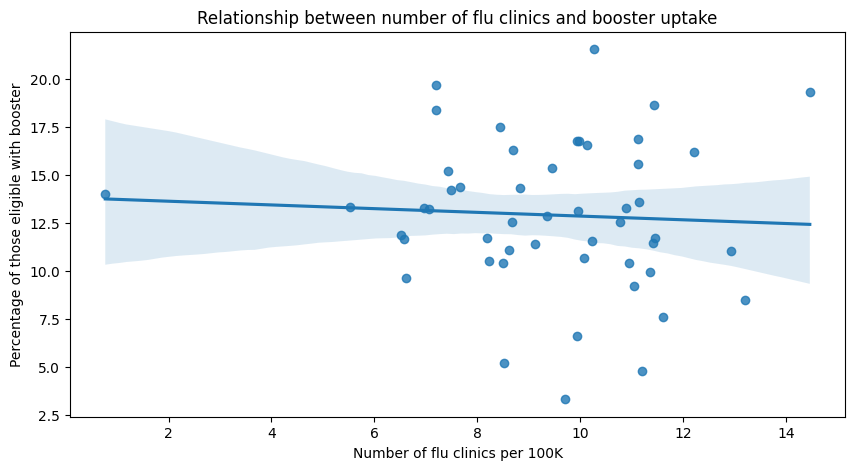

In [38]:
##This figure does not account for any covariates

fig, ax = plt.subplots(figsize=(10, 5), dpi=100)

sns.regplot(data=df_final, x="Clinics_100K", y="Elig_Pct")
ax.set(
    xlabel="Number of flu clinics per 100K",
    ylabel="Percentage of those eligible with booster",
)
ax.set(title="Relationship between number of flu clinics and booster uptake")

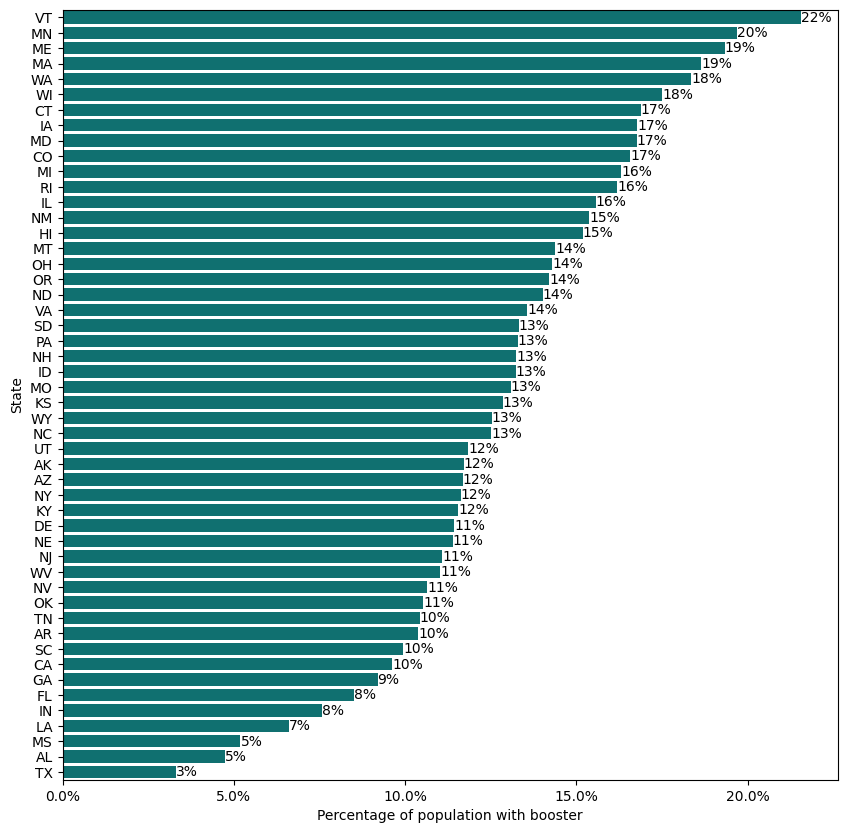

In [39]:
import matplotlib.ticker as mtick

fig, ax = plt.subplots(figsize=(10, 10), dpi=100)

sns.barplot(
    data=df_final,
    x="Elig_Pct",
    y="Location",
    order=df_final.sort_values("Elig_Pct", ascending=False).Location,
    color="Teal",
)

ax.set(ylabel="State", xlabel="Percentage of population with booster")
ax.xaxis.set_major_formatter(mtick.PercentFormatter())
for container in ax.containers:
    ax.bar_label(container, fmt="%.f%%")